In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt

In [268]:
retail = pd.read_excel('Online Retail.xlsx')

L'objectif est d'analyser le profil des clients sur une plateforme de e-commmerce. On dispose d'un dataset composé de plus 500k transactions.

La table des transactions est composée des colonnes suivantes:

- InvoiceNo: identifiant de la facture. Lorsque ce dernier commence par la lette 'C', il s'agit d'un remboursement.

- StockCode: identifiant du produit acheté.

- Description: description du produit.

- Quantity: quantité achetée, la valeur est négative lorsqu'il s'agit d'un remboursement.

- InvoiceDate: Date de l'achat.

- CustomerID: identifiant du client.

- UnitPrice: prix unitaire du produit.

- Country: pays dans lequel réside l'acheteur.

**Existe-t-il des valeurs manquantes dans le dataset?**

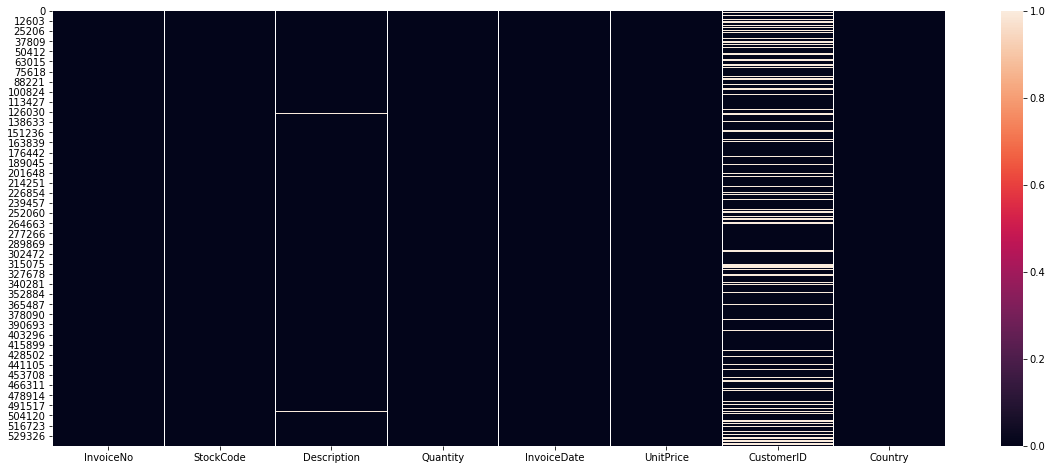

In [6]:
plt.figure(figsize=(20,8))
sns.heatmap(retail.isna())
plt.show()

Les valeurs manquantes se concentrent principalement sur la case 'CustomerID'. Peut-être qu'il s'agit d'un bug lors de l'extraction des données? Ou peut être qu'il s'agit de clients ayant effectué des achats sans s'être enregsitrés.

Pour analyser le comportement des clients on a besoin de connaitre leur identifiant unique. On va donc supprimer toutes les observations qui ne disposent pas de l'identifiant client.

In [269]:
retail_cleaned = retail.dropna()

**Quelle est la période couverte par ce dataset?**

In [18]:
# on ordonne le dataset selon la colonne invoiceDate
retail_cleaned = retail_cleaned.sort_values(by='InvoiceDate', ascending=True)
(retail_cleaned.InvoiceDate.iloc[-1] - retail_cleaned.InvoiceDate.iloc[0]).days

373

Le dataset couvre une période de 373jours.

Lorsque 'InvoiceNo' commence par la lettre 'c', il s'agit d'une annulation de commande. Créons une nouvelle variable binaire qui prend la valeur '1' lorsque la transaction est une annulation.

In [274]:
retail_cleaned.loc[:,'isCancelation'] = retail_cleaned.InvoiceNo.astype(str).str.startswith('C')

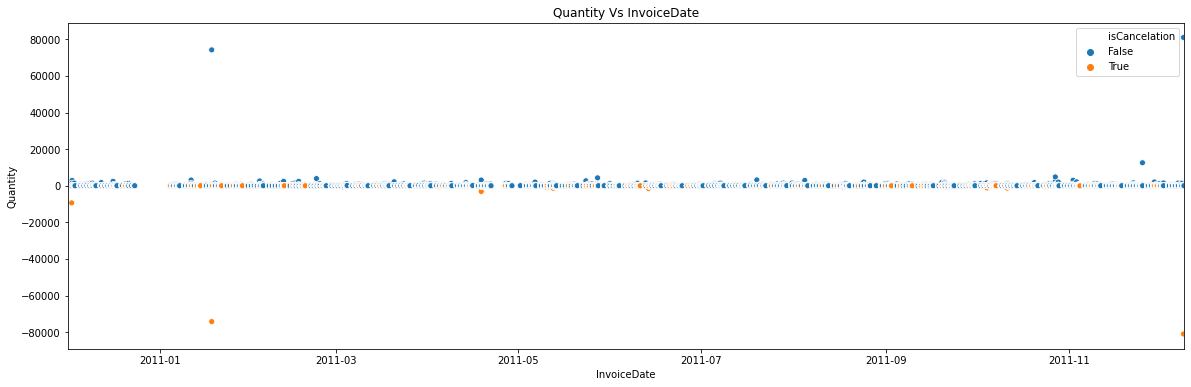

In [275]:
plt.figure(figsize=(20, 6))
sns.scatterplot(retail_cleaned.InvoiceDate, retail_cleaned.Quantity, hue=retail_cleaned['isCancelation'])
plt.xlim(retail_cleaned.InvoiceDate.min(), retail_cleaned.InvoiceDate.max())
plt.title('Quantity Vs InvoiceDate')
plt.show()

- En s'intéressant aux quantités de produits achetés on constate l'existance de quelques valeurs extrèmes.

- On constate aussi qu'il s'agit probablement d'une erreur, car ces mêmes commandes ont été annulés (voir le scatter plot)

Regardons de plus près la commande de `80995` produits.

In [41]:
retail_cleaned[retail_cleaned.Quantity==80995]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,isCancelation
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,False


In [42]:
retail_cleaned[retail_cleaned.Quantity==-80995]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,isCancelation
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09 09:27:00,2.08,16446.0,United Kingdom,True


Il s'agit du même client (ID = 16446), il a effectué sa commande le 2011-12-09 à 9:15 et puis surement il s'est rendu compte de son erreur ensuite il a aussitôt annulé celle-ci le même jours à 09:27.

On supprime toutes les paires commande-annulation pour ne pas nous induire en erreur lors de la phase d'analyse.

In [60]:
# extraire uniquement annulations
cancelations = retail_cleaned[retail_cleaned.isCancelation]

In [158]:
cancelations.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,isCancelation
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,True
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,True
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,True
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2010-12-01 10:24:00,3.45,17548.0,United Kingdom,True
240,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,True


In [125]:
transactions_to_delete = []
i = 0
for index, Series in cancelations.iterrows():
    mask = (retail_cleaned.StockCode == Series.StockCode) \
            & (retail_cleaned.Quantity.abs() == np.abs(Series.Quantity)) \
            & (retail_cleaned.UnitPrice==Series.UnitPrice) \
            & (retail_cleaned.Description==Series.Description) \
            & (retail_cleaned.InvoiceDate < Series.InvoiceDate)
    
    items = retail_cleaned[mask].sort_values(by='InvoiceDate', ascending=True).index.to_list()
    if len(items) != 0:
        # on recupere toute les transactions passé par le client, et considère que la transaction la plus récente correspond à la commande annulée
        transactions_to_delete.append(items[-1])
    i += 1
    print(f"Progress {i/len(cancelations):.2%}...", end='\r')

In [276]:
retail_cleaned = retail_cleaned[~retail_cleaned.index.isin(transactions_to_delete)]
retail_cleaned = retail_cleaned[~retail_cleaned.isCancelation]

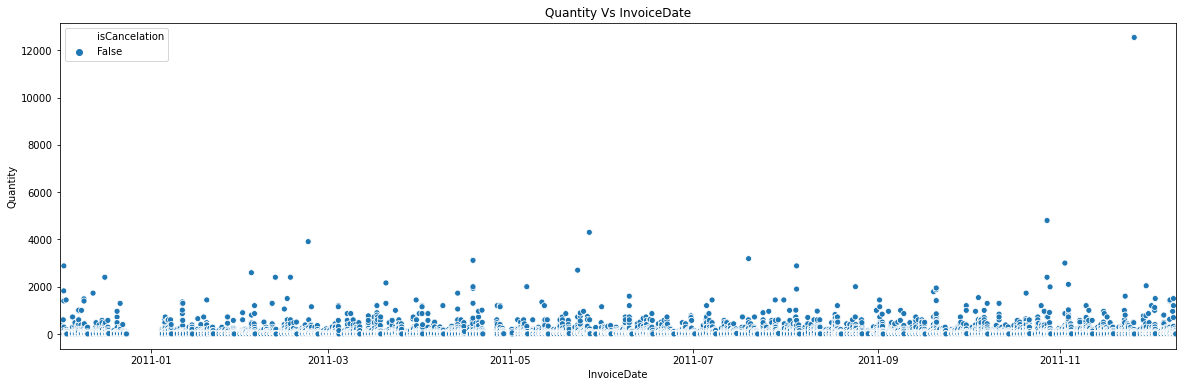

In [277]:
plt.figure(figsize=(20, 6))
sns.scatterplot(retail_cleaned.InvoiceDate, retail_cleaned.Quantity, hue=retail_cleaned['isCancelation'])
plt.xlim(retail_cleaned.InvoiceDate.min(), retail_cleaned.InvoiceDate.max())
plt.title('Quantity Vs InvoiceDate')
plt.show()

On a supprimé les annulations de commandes ainsi que les commandes correspondantes.

**Existe-il des transactions doublons ?**

In [182]:
retail_cleaned.duplicated().sum()

5052

In [183]:
retail_cleaned = retail_cleaned.drop_duplicates()

Qu'en est-t-il du prix unitaire?

In [144]:
retail_cleaned.UnitPrice.describe()

count    391602.000000
mean          3.056562
std          21.264146
min           0.000000
25%           1.250000
50%           1.850000
75%           3.750000
max        8142.750000
Name: UnitPrice, dtype: float64

On constate que la valeur min de `UnitPrice` est 0. 

In [164]:
retail_cleaned[retail_cleaned.UnitPrice==0].head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,isCancelation
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1.0,2010-12-05 14:02:00,0.0,12647.0,Germany,False


Quel est le vrai prix du produit `22841`?

In [166]:
retail_cleaned[retail_cleaned.StockCode==22841].head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,isCancelation
3925,536738,22841,ROUND CAKE TIN VINTAGE GREEN,2.0,2010-12-02 13:06:00,7.95,15827.0,United Kingdom,False
5111,536844,22841,ROUND CAKE TIN VINTAGE GREEN,2.0,2010-12-02 18:49:00,7.95,14236.0,United Kingdom,False


Peut-être que le client dispose d'un coupon qui lui permet d'acheter le produit gratuitement.

# Analyse des cohortes

Une cohorte est un groupe/segment d'utilisateurs qui partage une caractéristique ou un attribut commun durant une période donnée.

Par exemple:

- les utilisateurs qui se sont inscrit à la même date.

- les utilisateur qui apparatiennent à une même zone géographique.

In [184]:
# Define a function that will parse the date
def get_month(x): return dt(x.year, x.month, 1) 

retail_cleaned.loc[:,'InvoiceMonth'] = retail_cleaned['InvoiceDate'].apply(get_month) 
grouping = retail_cleaned.groupby('CustomerID')['InvoiceMonth'] 
retail_cleaned.loc[:,'CohortMonth'] = grouping.transform('min')
retail_cleaned.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,isCancelation,InvoiceMonth,CohortMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,False,2010-12-01,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,2010-12-01,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,False,2010-12-01,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,2010-12-01,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,2010-12-01,2010-12-01


On dispose d'une nouvelle variable `CohortMonth`. Elle permet de segmenter les clients selon la date à laquelle ils ont effectué leur premier achat. On considère deux clients ayant effectués leur premier achat le même mois, à des dates différentes, comme appartenant à la même cohorte.

In [267]:
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    return year, month

In [185]:
retail_cleaned.loc[:, 'CohorIndex'] = ((retail_cleaned.InvoiceMonth - retail_cleaned.CohortMonth)/np.timedelta64(1, 'M')).astype(int) + 1

In [186]:
dt_month = retail_cleaned.InvoiceMonth.dt.month - retail_cleaned.CohortMonth.dt.month 
dt_years = retail_cleaned.InvoiceMonth.dt.year - retail_cleaned.CohortMonth.dt.year 
dt_months = dt_month + dt_years*12 +1
retail_cleaned.loc[:, 'CohorIndex'] = dt_months

In [187]:
grouping = retail_cleaned.groupby(['CohortMonth', 'CohorIndex'])
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()

In [188]:
cohort_table = pd.pivot(data=cohort_data, index='CohortMonth', columns='CohorIndex', values='CustomerID')

In [189]:
cohort_table

CohorIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,885.0,324.0,286.0,339.0,318.0,352.0,320.0,306.0,313.0,350.0,331.0,445.0,235.0
2011-01-01,415.0,89.0,111.0,96.0,134.0,119.0,103.0,101.0,125.0,136.0,152.0,49.0,NaN
2011-02-01,381.0,71.0,71.0,108.0,103.0,93.0,96.0,106.0,94.0,116.0,26.0,NaN,NaN
2011-03-01,452.0,67.0,114.0,90.0,101.0,75.0,120.0,104.0,126.0,39.0,NaN,NaN,NaN
2011-04-01,300.0,63.0,61.0,63.0,59.0,68.0,64.0,78.0,22.0,NaN,NaN,NaN,NaN
2011-05-01,283.0,54.0,49.0,49.0,59.0,65.0,75.0,26.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,242.0,42.0,38.0,64.0,56.0,81.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,186.0,34.0,39.0,42.0,51.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,168.0,35.0,42.0,41.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Chaque ligne de `cohort_table` correspond à un segmend/cohort.

La colonne `1` correspond au nombre total de client par cohort (taille de la cohorte).

Les colonnes suivantes représentent le nombre de clients fidèles par cohorte ayant refait des achats les mois suivants. À partir de cette table on peut calculer le taux de rétention des clients. Le taux de rétention nous permet de connaitre le pourcentage des clients restés actifs par cohorte plusieurs mois après la date de leur premier achat.

In [190]:
retention = cohort_table.divide(cohort_table.iloc[:,0], axis=0)
retention.round(2)*100

CohorIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0,37.0,32.0,38.0,36.0,40.0,36.0,35.0,35.0,40.0,37.0,50.0,27.0
2011-01-01,100.0,21.0,27.0,23.0,32.0,29.0,25.0,24.0,30.0,33.0,37.0,12.0,NaN
2011-02-01,100.0,19.0,19.0,28.0,27.0,24.0,25.0,28.0,25.0,30.0,7.0,NaN,NaN
2011-03-01,100.0,15.0,25.0,20.0,22.0,17.0,27.0,23.0,28.0,9.0,NaN,NaN,NaN
2011-04-01,100.0,21.0,20.0,21.0,20.0,23.0,21.0,26.0,7.0,NaN,NaN,NaN,NaN
2011-05-01,100.0,19.0,17.0,17.0,21.0,23.0,27.0,9.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,17.0,16.0,26.0,23.0,33.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,18.0,21.0,23.0,27.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,21.0,25.0,24.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


On peut constater que 50% des clients ayant effectué leur premier achat en décembre 2010 sont revenues sur la plateforme 11mois après.

**LES METIERS CONNAISSENT L'ENSEMBLE DES ACTIONS MENEES pendant cette periode, l'idée est donc de supperposé les chiffres qu'on observe dans la table ci-dessous avec les actions menées**.

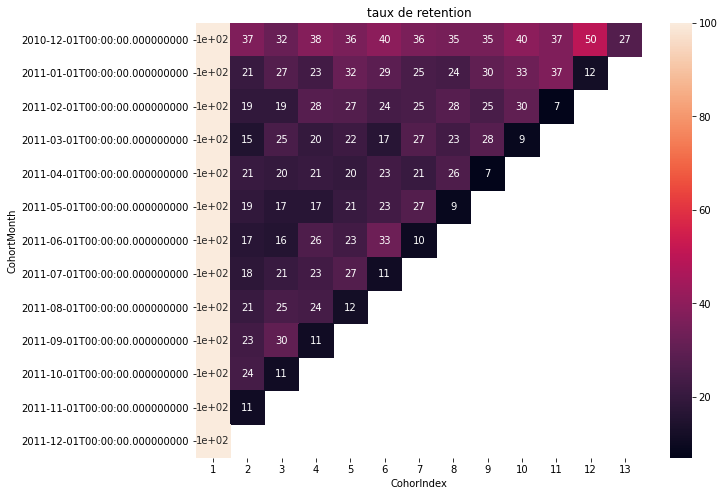

In [191]:
# faire le plot d'un heatmap
plt.figure(figsize=(10, 8))
plt.title('taux de retention')
sns.heatmap(data=retention.round(2)*100,
            annot=True)

plt.show()

## Analyse du segment de client ayant effectué leur premier achat le 2010-12 (première cohorte)

La méthode de segmentation RFM permet un classement des clients en fonction de leurs habitudes d'achat. On peut ainsi optimiser une stratégie marketing en fonction de nos clients.

Le classement RFM se fait en fonction de 3 critères :

- Récence : date du dernier achat ou dernier contact client
- Fréquence : fréquence des achats sur une période de référence donnée
- Montant : somme des achats cumulés sur cette période

Calculons la RFM par rapport à la date la plus récente du dataset

In [187]:
recent_date = retail_cleaned.InvoiceDate.max() + pd.Timedelta(1, unit='D')
recent_date

Timestamp('2011-12-10 12:50:00')

In [219]:
rfm = retail_cleaned[retail_cleaned.CohortMonth=='2010-12-01'].groupby(['CustomerID']).agg({'InvoiceDate': lambda x : (recent_date - x.max()).days,
                                      'InvoiceNo':'count', 'total_bill': 'sum'})
rfm = rfm.rename(columns={'InvoiceDate': 'Recence', 'InvoiceNo': 'Frequence', 'total_bill': 'Montant'})
rfm.head()

,Recence,Frequence,Montant
CustomerID,,,
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12370.0,51,167,3545.69
12377.0,315,77,1628.12
12383.0,185,99,1850.56


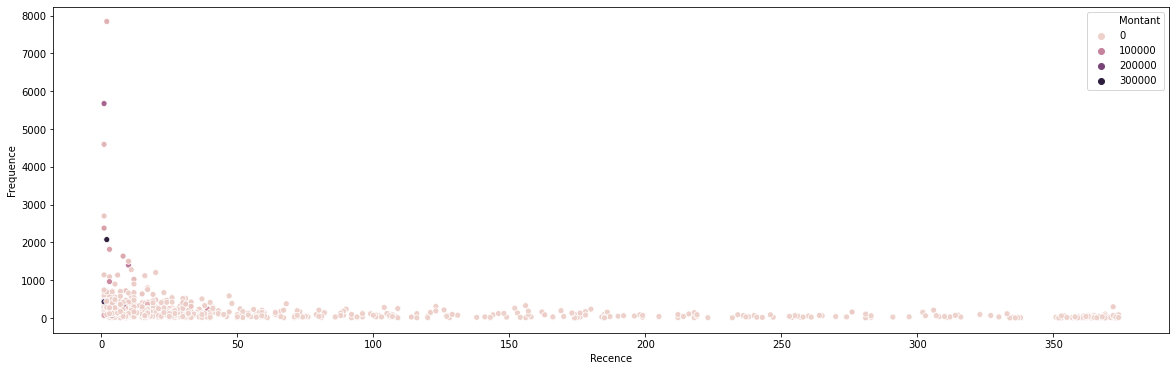

In [243]:
plt.figure(figsize=(20,6))
sns.scatterplot(x=rfm.Recence, y=rfm.Frequence, hue=rfm.Montant)
plt.title()
plt.show()

- Certain client n'ont pas effecuté d'achat depuis plus de 5mois (churn?)

- La majorité des clients de cette cohorte sont actifs.

Strategie: segmenter la variable `Recence` en trois catégorie

- `Actif`: achat dans les 30jours.

- `inactif`: dernier achat remontant à plus de 30jours.

- `churn`: dernier achat remontant à plus de 250jours.

L'idée est d'identifier les clients `inactif` et les cibler afin d'éviter qu'ils passent à la catégorie `churn`.

**PS:** si on dispose d'un dataset contenant des données privées sur les clients on pourra s'appuyer dessus pour entrainer un modèle qui permettra de prédire le 'churn'.

Le but est de segmenter les clients sur une période de 12mois selon le montant total et la fréquence de leurs achats. On décompose également les clients en plusieurs segments selon leur récence.

On discrétise les variables quantitatives `Recence`, `Frequence` et `Montant` afin de segmenter les clients en fonction de leur RFM.

- On divise chacune des variables en 4 intervalles (quartiles) et on assigne à chaque plage un label (un score de 1 à 4 inclut).

- Pour la récense, plus la valeur est petite meilleur est le score qu'on assigne au client (client fidèle et actif)

In [220]:
r_labels =range(4,0,-1)
f_labels=range(1,5)
m_labels=range(1,5)
r_quartiles = pd.qcut(rfm['Recence'], q=4, labels = r_labels)
f_quartiles = pd.qcut(rfm['Frequence'],q=4, labels = f_labels)
m_quartiles = pd.qcut(rfm['Montant'],q=4,labels = m_labels)
rfm = rfm.assign(R=r_quartiles,F=f_quartiles,M=m_quartiles)

## Analyse de la table RFM

In [221]:
rfm.head()

,Recence,Frequence,Montant,R,F,M
CustomerID,,,,,,
12347.0,2,182,4310.00,4,3,4
12348.0,75,31,1797.24,2,1,3
12370.0,51,167,3545.69,2,3,3
12377.0,315,77,1628.12,1,2,2
12383.0,185,99,1850.56,1,2,3


Quel est le client ayant le plus depensé ?

In [223]:
rfm.sort_values(by='Montant', ascending=False).head(3)

,Recence,Frequence,Montant,R,F,M
CustomerID,,,,,,
14646.0,2,2076,280206.02,4,4,4
18102.0,1,431,259657.30,4,4,4
17450.0,8,337,194550.79,4,4,4


On remarque que les clients les plus dépensier, sont également très actifs et achètent très souvent.

- Créons une nouvelle variable catégorielle (ordinal) `segment_rfm`.
- La variable `segment_rfm`est une somme pondérée des scores `R`, `F`et `M`. 
- On assigne un poids de 100, 10 et 1 respectivement à `R`, `F`et `M`. 

In [224]:
rfm['segment_rfm'] = rfm.R.astype(str) + rfm.F.astype(str) + rfm.M.astype(str)

In [225]:
rfm.sort_values(by='segment_rfm', ascending=False).head(10)

,Recence,Frequence,Montant,R,F,M,segment_rfm
CustomerID,,,,,,,
14606.0,1,2700,12156.65,4,4,4,444
14085.0,2,450,4448.54,4,4,4,444
13798.0,1,349,37153.85,4,4,4,444
17757.0,1,741,5605.29,4,4,4,444
17735.0,2,690,13110.02,4,4,4,444
13969.0,7,626,9053.94,4,4,4,444
14031.0,7,250,17286.86,4,4,4,444
17706.0,4,382,10504.49,4,4,4,444
14092.0,8,214,4076.91,4,4,4,444


In [267]:
rfm.describe()

,Recence,Frequence,Montant
count,885.000000,885.000000,885.000000
mean,97.859887,191.315254,5098.472565
std,129.294215,426.224415,17489.904472
min,1.000000,1.000000,15.000000
25%,9.000000,35.000000,598.200000
50%,27.000000,99.000000,1661.060000
75%,153.000000,210.000000,3981.360000
max,374.000000,7847.000000,280206.020000


In [229]:
rfm.segment_rfm.nunique()

59

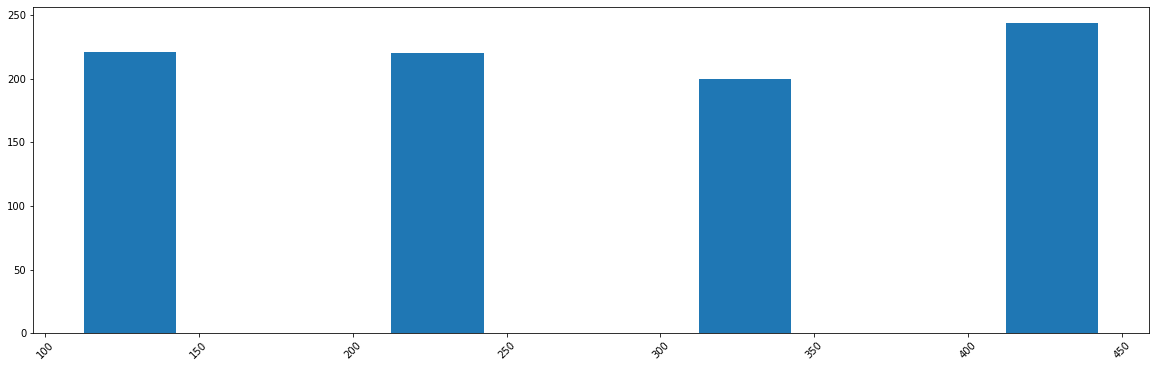

In [235]:
plt.figure(figsize=(20,6))
plt.hist(rfm.segment_rfm.astype(int), rwidth=.9)
plt.xticks(rotation=45)
plt.show()

- `segment_rfm` donne plus de poids aux clients actifs et qui achètent très souvent.

`segment_rfm` est donc pertinent pour évaluer la qualité des clients ayant effectué leur premier achat il y'a 12mois (première cohorte)

In [249]:
rfm['client_seg'] = pd.cut(rfm.segment_rfm.astype(int), bins=3, labels=['Bronze', 'Sliver', 'Gold'])

In [252]:
rfm.client_seg.value_counts()

Gold      331
Bronze    328
Sliver    226
Name: client_seg, dtype: int64

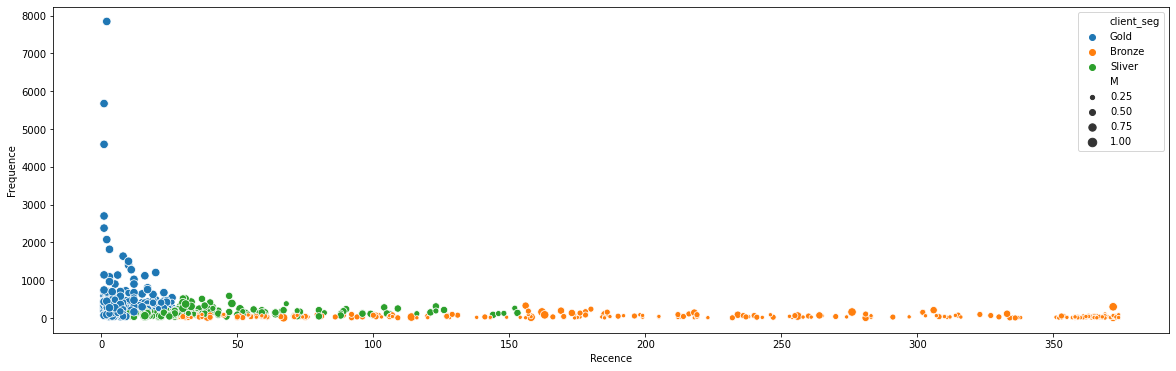

In [266]:
plt.figure(figsize=(20,6))
sns.scatterplot(x=rfm.Recence, y=rfm.Frequence, size=rfm.M.astype(int)/4, hue=rfm.client_seg)

plt.show()

# Segmentation client avec K-means

## Préparation des données


Hypothese k-means:
- distribution symetrique des variables (pas de skew)
- les variables ont la même variance et la même moyenne.

Pour que K-means fonctionne bien, il faut reformater les données afin qu'elles respectent les hypothèses ci-dessous.

In [269]:
rfm.describe()

,Recence,Frequence,Montant
count,885.000000,885.000000,885.000000
mean,97.859887,191.315254,5098.472565
std,129.294215,426.224415,17489.904472
min,1.000000,1.000000,15.000000
25%,9.000000,35.000000,598.200000
50%,27.000000,99.000000,1661.060000
75%,153.000000,210.000000,3981.360000
max,374.000000,7847.000000,280206.020000


Nos variables ne respectent pas les hypothèses de k-means en terme de variance et de moyenne.

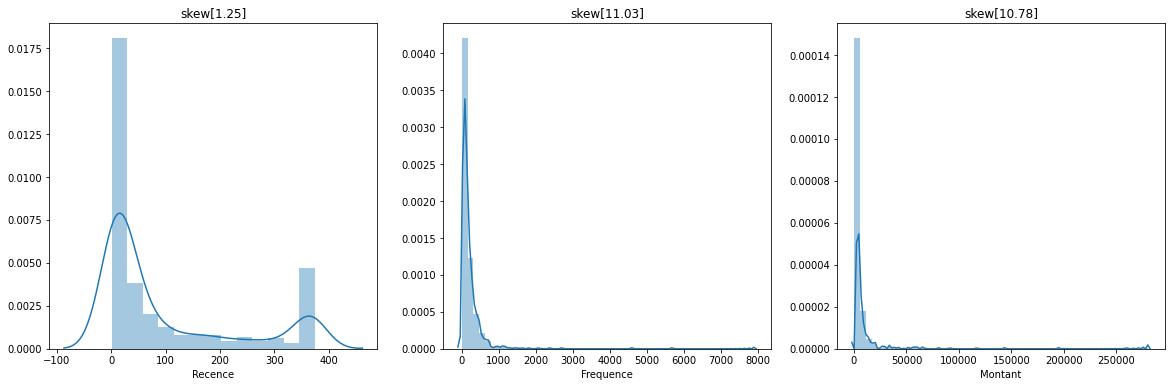

In [292]:
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
sns.distplot(rfm.Recence)
plt.title(f"skew[{round(rfm.Recence.skew(),2)}]")
plt.subplot(1,3,2)
sns.distplot(rfm.Frequence)
plt.title(f"skew[{round(rfm.Frequence.skew(),2)}]")
plt.subplot(1,3,3)
sns.distplot(rfm.Montant)
plt.title(f"skew[{round(rfm.Montant.skew(),2)}]")
plt.show()

Pour corriger l'asymétrie des variables, on appliquera une transfromation logarithmique.

In [293]:
Recence_log = np.log(rfm.Recence)
Frequence_log = np.log(rfm.Frequence)
Montant_log = np.log(rfm.Montant)

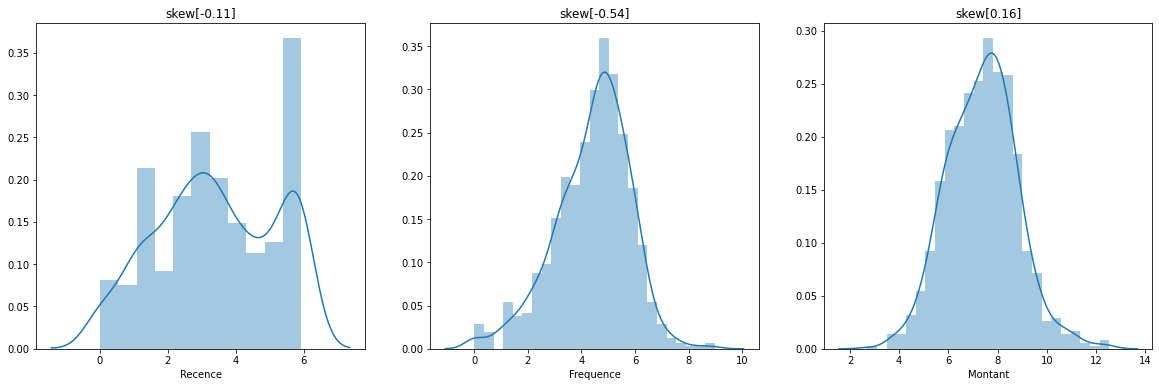

In [295]:
plt.figure(figsize=(20,6))

plt.subplot(1,3,1)
sns.distplot(Recence_log)
plt.title(f"skew[{round(Recence_log.skew(),2)}]")

plt.subplot(1,3,2)
sns.distplot(Frequence_log)
plt.title(f"skew[{round(Frequence_log.skew(),2)}]")

plt.subplot(1,3,3)
sns.distplot(Montant_log)
plt.title(f"skew[{round(Montant_log.skew(),2)}]")

plt.show()

- Nos variables sont maintenant moins asymétriques.

Verifions la moyenne et l'ecart type de nos variables.

In [299]:
rfm_log = pd.DataFrame()
rfm_log = rfm_log.assign(Recence=Recence_log, Frequence=Frequence_log, Montant= Montant_log)

In [300]:
rfm_log.describe()

,Recence,Frequence,Montant
count,885.000000,885.000000,885.000000
mean,3.400148,4.417172,7.373841
std,1.745931,1.391372,1.421090
min,0.000000,0.000000,2.708050
25%,2.197225,3.555348,6.393925
50%,3.295837,4.595120,7.415211
75%,5.030438,5.347108,8.289379
max,5.924256,8.967887,12.543280


Il subsiste encore quelques différences au niveau de la variance et la moyenne de nos trois variables.

- On centre nos trois variables autour de 0, en soustriant la valeur moyenne.

In [306]:
rfm_log_centered = (rfm_log - rfm_log.mean()).round(2)
rfm_log_centered.describe()

,Recence,Frequence,Montant
count,885.000000,885.000000,885.000000
mean,0.000056,0.000113,0.000011
std,1.745677,1.391270,1.421108
min,-3.400000,-4.420000,-4.670000
25%,-1.200000,-0.860000,-0.980000
50%,-0.100000,0.180000,0.040000
75%,1.630000,0.930000,0.920000
max,2.520000,4.550000,5.170000


On normalize la variance en divisant par l'ecart type.

In [309]:
rfm_log_centered_scaled = rfm_log_centered/rfm_log_centered.std()
rfm_log_centered_scaled.describe()

,Recence,Frequence,Montant
count,885.000000,885.000000,885.000000
mean,0.000032,0.000081,0.000008
std,1.000000,1.000000,1.000000
min,-1.947669,-3.176953,-3.286169
25%,-0.687412,-0.618140,-0.689603
50%,-0.057284,0.129378,0.028147
75%,0.933735,0.668454,0.647382
max,1.443566,3.270392,3.638007


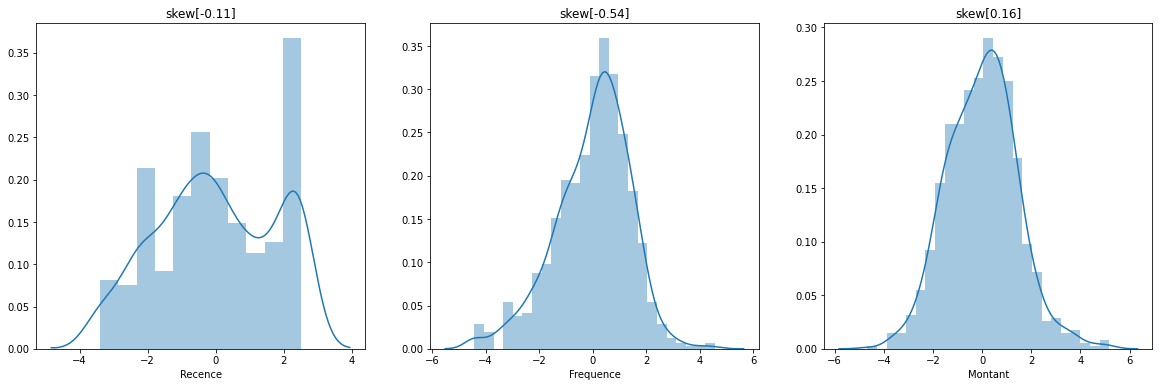

In [310]:
plt.figure(figsize=(20,6))

plt.subplot(1,3,1)
sns.distplot(rfm_log_centered.Recence)
plt.title(f"skew[{round(rfm_log_centered.Recence.skew(),2)}]")

plt.subplot(1,3,2)
sns.distplot(rfm_log_centered.Frequence)
plt.title(f"skew[{round(rfm_log_centered.Frequence.skew(),2)}]")

plt.subplot(1,3,3)
sns.distplot(rfm_log_centered.Montant)
plt.title(f"skew[{round(rfm_log_centered.Montant.skew(),2)}]")

plt.show()

On a réussi à reformater les données pour se conformer aux exigences/hypothèses du modèle 'k-means'.

Pour fonctionner 'k-means dois connaitre le nombre de cluster à identifier.

- Un nombre K grand peut conduire à un partitionnement trop fragmenté des données. Ce qui empêchera de découvrir des patterns intéressants dans les données.

- un nombre de clusters trop petit, conduira à avoir, potentiellement, des cluster trop généralistes contenant beaucoup de données. Dans ce cas, on n'aura pas de patterns "fins" à découvrir.

Pour choisir K, on utilise la méthode du coude (elbow criterion). La méthode consiste à créer plusieurs modèle avec differentes valeurs de K. Pour chaque modèle on calcule la variance des centroid (les centres de cluster identifié par le modèle)

In [330]:
from sklearn.cluster import KMeans
ks = range(1,10)
results = []
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=24)
    kmeans.fit(rfm_log_centered_scaled)
    results.append([k, kmeans.inertia_])

results = np.array(results)

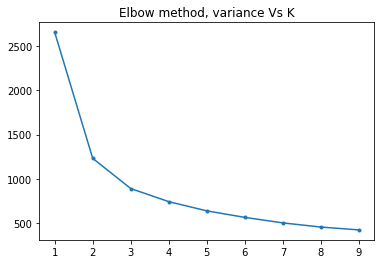

In [338]:
plt.figure()
plt.plot(results[:,0], results[:,1], marker='.')
plt.title('Elbow method, variance Vs K')
plt.show()

La pointe du coude se trouve ici à `k=3`.

In [352]:
kmeans = KMeans(n_clusters=3, random_state=24)
kmeans.fit(rfm_log_centered_scaled)

KMeans(n_clusters=3, random_state=24)

In [353]:
pred_segments = pd.Series(kmeans.predict(rfm_log_centered_scaled))

In [354]:
rfm = rfm.reset_index()
rfm['kmeans_clusters'] = pred_segments

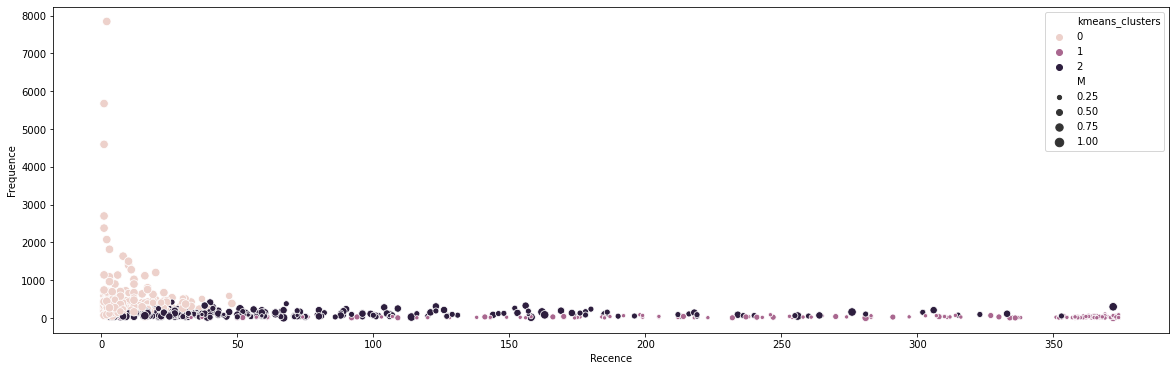

In [356]:
plt.figure(figsize=(20,6))
sns.scatterplot(x=rfm.Recence, y=rfm.Frequence, size=rfm.M.astype(int)/4, hue=rfm.kmeans_clusters)
plt.show()

In [370]:
rfm.groupby('kmeans_clusters').agg({'Recence': 'mean', 'Frequence': 'mean', 'Montant': ['mean', 'count']}).round(2)

Recence Frequence   Montant      
                   mean      mean      mean count
kmeans_clusters                                  
0                  9.13    411.16  12326.90   308
1                281.91     22.65    383.95   217
2                 62.83    104.90   1755.96   360

Kmeans nous a identifié 3 clusters:

Cluster 0:

- Composé de 308 clients qui dépensent en moyenne 12,3K$, très actifs car leur dernier achat remonte en moyenne de 9jours. En moyenne, ces clients ont effectué plus de 400 achats sur les 12 derniers moins.

Cluster 1:

- Composé de 217 clients qui dépensent en moyenne 383.95$, **inactifs** car leur dernier achat remonte en moyenne de ~282jours. Sur les 12 derniers moins ils ont effectué en moyenne 62 achats.

Cluster 2:

- Composé de 360 clients qui dépensent en moyenne 1755.96$, leur dernier achat remonte à 2moins. Sur les 12 derniers moins ils ont effectué en moyenne 62 achats.


## snake plot

- Technique utilisée en marketing permettant de comparer different segments.
- Permet de visualiser graphiquement les attributs de chaque segment.



pour construire le `snake plot`il faut normaliser les données.

In [376]:
rfm_log_centered_scaled['kmeans_cluster'] = pred_segments

In [379]:
rfm_melt = pd.melt(rfm_log_centered_scaled, id_vars=['CustomerID', 'kmeans_cluster'],
        value_vars=['Recence', 'Frequence', 'Montant'],
        var_name='Attribute',
        value_name='Value'
       )

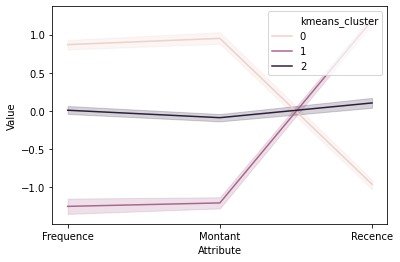

In [381]:
sns.lineplot(x='Attribute', y='Value', hue='kmeans_cluster', data=rfm_melt)
plt.show()

Le plot permet de voir clairement la difference en terme de `Recence`, `Fréquence`et `Montant` entre les différent clusters identifiés.

## Règles d'association

Considérons chaque `invoiceNo` comme un panier. L'objectif est d'analyser toutes factures et d'en extraire des règles d'association entre les produits. 

In [232]:
invoices = retail_cleaned.groupby('InvoiceNo')['StockCode'].apply(list)

In [233]:
invoices.iloc[0]

['85123A', 71053, '84406B', '84029G', '84029E', 22752, 21730]

Quel est le nombre de produits uniques dans ce dataset?

In [217]:
retail_cleaned.StockCode.nunique()

3651

In [234]:
invoices_list = [[str(product) for product in products] for index, products in invoices.iteritems()]

Reformatons les données en transformant la liste de liste (liste de factures/paniers avec chaque facture contenant la liste de produits achetés) en matrice de `n` lignes correspondant aux différentes factures, et `m` colonnes correspondant aux différents produits du magazin.

In [236]:
from mlxtend.preprocessing import TransactionEncoder
encoder = TransactionEncoder().fit(invoices_list)
onehote = encoder.transform(invoices_list)

transactions_matrix = pd.DataFrame(onehote, columns=encoder.columns_)

transactions_matrix.head(2)

,10002,10080,10120,10123C,10124A,10124G,10125,10133,10135,11001,...,90214V,90214W,90214Y,90214Z,BANK CHARGES,C2,DOT,M,PADS,POST
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [247]:
transactions_matrix.shape

(18436, 3651)

Dans notre matrice, on dispose de 18434 factures et 3651 produits.

In [249]:
transactions_matrix.mean().sort_values(ascending=False).head(4)

85123A    0.105934
22423     0.087438
85099B    0.085214
84879     0.074094
dtype: float64

`85123A` est le produit le plus acheté.

In [265]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

frequent_itemsets = apriori(transactions_matrix, min_support=0.01, use_colnames=True)

rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.6)

Pour extraire les règles d'association, on spécifie un critère de `suppor` de 1% et de `confianc` de 60%;

In [266]:
rules.sort_values(by=['confidence', 'support'], ascending=[False, False])

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
46,(23172),(23171),0.011879,0.014428,0.010631,0.894977,62.029320,0.010460,9.384357
131,"(22698, 22423, 22699)",(22697),0.013072,0.035908,0.011337,0.867220,24.151158,0.010867,7.260818
113,"(22698, 22699)",(22697),0.022131,0.035908,0.019147,0.865196,24.094796,0.018353,7.151810
44,(23172),(23170),0.011879,0.017357,0.010252,0.863014,49.720377,0.010045,7.173291
130,"(22698, 22697, 22423)",(22699),0.013181,0.040573,0.011337,0.860082,21.198499,0.010802,6.857083
...,...,...,...,...,...,...,...,...,...
98,"(22383, 22384)",(20727),0.020937,0.056520,0.012638,0.603627,10.679910,0.011455,2.380283
89,"(20727, 20726)",(22382),0.018388,0.053048,0.011065,0.601770,11.343794,0.010090,2.377901
134,"(22697, 22423)","(22698, 22699)",0.018876,0.022131,0.011337,0.600575,27.137734,0.010919,2.448191
100,"(22382, 20728)",(22383),0.020775,0.055869,0.012476,0.600522,10.748764,0.011315,2.363413


- Avec les critères specifiés, l'algorithme `Apriori` a identifié 135 règles.

On peut maitenant utiliser ces règles pour recommender aux clients des produits pertinents en fonction de leur historique d'achats.